# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [104]:
# Imagen para estilo
#!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output_mias3

#Descargo estas imagenes del buscador de google
!wget https://s6.eestatic.com/2019/05/08/actualidad/Actualidad_396973085_130537292_1706x960.jpg
!wget https://www.turismonuevayork.com/wp-content/uploads/2011/06/Edificio-Woolworth.jpg
!wget https://landuse.co.uk/wp-content/uploads/2019/08/Hyde-Park-Parade-Ground.jpg


'\n#Descargo estas imagenes del buscador de google\n!wget https://s6.eestatic.com/2019/05/08/actualidad/Actualidad_396973085_130537292_1706x960.jpg\n!wget https://www.turismonuevayork.com/wp-content/uploads/2011/06/Edificio-Woolworth.jpg\n!wget https://landuse.co.uk/wp-content/uploads/2019/08/Hyde-Park-Parade-Ground.jpg\n'

In [105]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [106]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/Hyde-Park-Parade-Ground.jpg")
style_reference_image_path = Path("/content/Actualidad_396973085_130537292_1706x960.jpg")
result_prefix = Path("/content/output_mias3")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:

- style_weight: factor que controla la proporcion de aporte de estilo en la loss total, el mismo multiplicara el componente de estilo de la loss total. Es el alpha de la ecuacion. (β)
- content_weight: de forma similar al anterior determinara el impacto que tendra la loss del contexto a la loss total. Corresponde al beta de la ecuacion. (α)
- total_variation_weight: factor de contribucion de cada capa al estilo. (α/β)

      Ltotal(p,a,x) = αLcontent(p, x) + βLstyle(a,x) 

In [107]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

"""
total_variation_weight = 0.3
style_weight = 0.95
content_weight = 0.5
"""




'\ntotal_variation_weight = 0.3\nstyle_weight = 0.95\ncontent_weight = 0.5\n'

In [108]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta: 

Basicamente esta función recibe el path de una imagen y devuelve un numpy.array o un tf.Tensor float32 según corresponda. Mediante load_img carga la imagen, img_to_array() 'castea' la imagen a numpy.array. Luego la anteúltima linea agrega una dimensión y la última linea convierte los colores RGB a BGR y además para cada canal de color realiza un zero-centered (respecto de la ImageNet dataset).

In [109]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

Efectua el procesamiento inverso, ahora transforma la imagen de BGR a RGB y quita el "zero-center" que había hecho en el punto anterior.

In [110]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [111]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [112]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [113]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [114]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?

La matriz de estilo tambien es llamada 'Gram matrix'. Dados 'n' vectores, la matriz Gram para ese set de vectores se calcula como el producto punto entre 
${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$.


Basicamente, $G_{ij}$ compara qué tan similar es $v_i$ respecto de $v_j$. Para este problema en particular es el producto interno de las respuestas de los filtros en una capa, lo que me determina la correlación entre features de una imagen. 


- ¿Por qué se permutan las dimensiones de x?

Para que se correspondan las dimensiones al momento de realizar el producto entre sí misma ($x$) y su transpuesta ($x^T$).

In [115]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta: 
- style_loss : mide la suma de las distancias euclideanas entre la imagen que aporta el estilo y la generada normalizada por sus dimensiones.

- content_loss : mide las distancias euclidianas entre los features de la imagen base y la imagen de combinación. El objetivo es que la imagen generada sea parecida a la de contenido.

- total_variation_loss : penaliza cambios abruptos en la loss con el fin que la imagen sea coherente.

In [116]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [117]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [118]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [119]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [120]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

La función eval_loss_and_grads evalua la loss y el gradiente.
La clase evaluator inicializa en el init la loss y el gradiente como _None_ para luego actualizar estos valores con la funcion mencionada anteriormente.
El método fmin_l_bfgs_b de la librería Scipy minimiza una función recibida como parámetro y le realiza una optimización para obtener su mínimo. Utiliza para eso el algoritmo L-BFGS-B, por lo visto sería éste un metodo computacionalmente más economico y rápido que otros como por ej. Adam.

In [121]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [122]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [123]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 6665536000.0
Image saved as /content/output_mias3/output_at_iteration_0.png
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 3078198800.0
Image saved as /content/output_mias3/output_at_iteration_1.png
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 2144671500.0
Image saved as /content/output_mias3/output_at_iteration_2.png
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 1728107900.0
Image saved as /content/output_mias3/output_at_iteration_3.png
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 1430715800.0
Image saved as /content/output_mias3/output_at_iteration_4.png
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 1283705300.0
Image saved as /content/output_mias3/output_at_iteration_5.png
Iteration 5 completed in 4s
Start of iteration 6
Current loss value: 1182955800.0
Image saved as /content/output_mias3/output_at_iteration_6.png
Iteration 6 c

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:




Distintos style transfer según parametros:



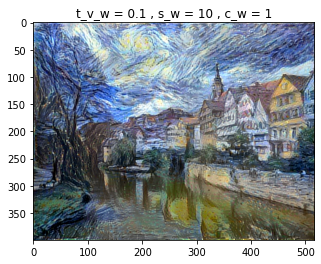

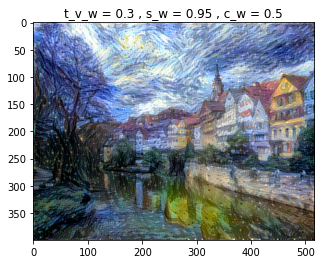

In [147]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print('\nDistintos style transfer según parametros:\n')

img = mpimg.imread('/content/output_1/output_at_iteration_99.png')
imgplot = plt.imshow(img)
plt.title('t_v_w = 0.1 , s_w = 10 , c_w = 1')
plt.show()

img = mpimg.imread('/content/output_2/output_at_iteration_99.png')
imgplot = plt.imshow(img)
plt.title('t_v_w = 0.3 , s_w = 0.95 , c_w = 0.5')
plt.show()


# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

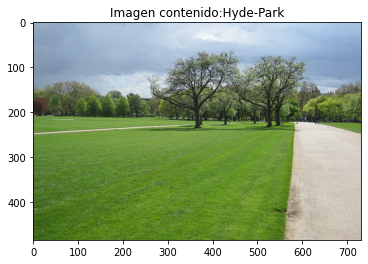

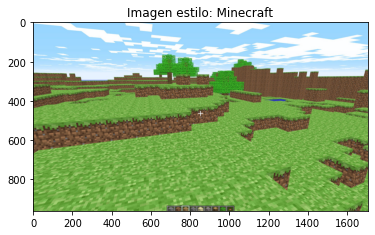

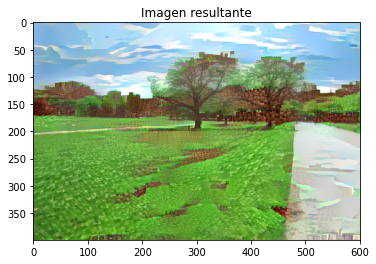

In [144]:
img = mpimg.imread('/content/Hyde-Park-Parade-Ground.jpg')
imgplot = plt.imshow(img)
plt.title('Imagen contenido:Hyde-Park')
plt.show()


img = mpimg.imread('/content/Actualidad_396973085_130537292_1706x960.jpg')
imgplot = plt.imshow(img)
plt.title('Imagen estilo: Minecraft')
plt.show()


img = mpimg.imread('/content/output_mias3/output_at_iteration_99.png')
imgplot = plt.imshow(img)
plt.title('Imagen resultante')
plt.show()
